# Tutorial 1: Fiscal and Monetary Policy in the Canonical HANK Model

NBER Heterogeneous-Agent Macro Workshop

June 2025

This notebook aims to solve for the effects of fiscal and monetary policy in the canonical HANK model we introduced in the lectures.

Approach:
- We will set up the "household block" of the model.
- We use the model to compute household jacobians, such as the iMPC matrix.
- We solve IKC like equations (either in goods or asset market) to compute IRFs to fiscal and monetary policy shocks.

Tomorrow, we will show you how this can be simplified using the full `sequence-jacobian` toolbox.

The first step is to import packages we'll need for this notebook.

In [1]:
import numpy as np  # numpy helps us perform linear algebra calculations
import matplotlib.pyplot as plt  # helps us plot
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc

Before we start, we'll define some basic model parameters we need below. We store them in the `calibration` dictionary:

In [2]:
calibration = {'eis': 1,  # EIS
               'rho_e': 0.91**(1/4),  # persistence, annual rho=0.91 from IKC
               'sd_e': 0.92,  # cross-sectional std deviation of income from IKC
               'min_a': 0.,  # Minimum asset level on the grid
               'max_a': 4_000,  # Maximum asset level on the grid
               'n_a': 400,  # Number of asset grid points
               'n_e': 11}  # Number of productivity grid points

## (1) Setting up the household block

First, we will set up a `HetBlock` that represents our heterogeneous household block.

For the sake of clarity, we directly write these in the code block below, but since it's a really standard `Block`, we can also import it directly from within `sequence-jacobian` by calling `from sj.hetblocks.hh_sim import hh_init, hh`.

Pieces here:
 - `hh_init` initializies the values for the backward iteration, which is `Va`, the derivative of the value function with respect to assets, defined over a joint grid of income and asset states. We always write the grids as (income state, asset state).
 - `hh_raw` is a single backward step of the endogenous gridpoints method, covered in an earlier session.
 - the decorator `@sj.het` turns the subsequent function definition into a `HetBlock`. We'll have similar decorators below to define blocks.

In [3]:
# initialize
def hh_init(a_grid, z, rp, eis):
    coh = (1 + rp) * a_grid[np.newaxis, :] + z[:, np.newaxis]
    Va = (1 + rp) * coh ** (-1 / eis)
    return Va

# backward step
@sj.het(exogenous='Pi',  # <-- this means our transition matrix will be fed into the model as Pi (use this for forward iteration)
        policy='a',  # <-- this means our endogenous state variable is a, defined over grid a_grid (we use this to check convergence)
        backward='Va',  # <-- this means we're iterating over variable Va, whose future value is Va_p (solver needs to know this to iterate!)
        backward_init=hh_init)
def hh_raw(Va_p, a_grid, z, rp, beta, eis):
    uc_endog = beta[:, np.newaxis] * Va_p  # u'(c') on tomorrow's grid
    c_endog = uc_endog ** (-eis)  # c' on tomorrow's grid
    coh = (1 + rp) * a_grid[np.newaxis, :] + z[:, np.newaxis]  # cash on hand on today's grid
    a = sj.interpolate.interpolate_y(c_endog + a_grid, coh, a_grid)  # this plots (c_next + a', a') pairs and computes policy a' from interpolation on coh
    sj.misc.setmin(a, a_grid[0])  # impose borrowing constraint
    c = coh - a  # back out consumption
    Va = (1 + rp) * c ** (-1 / eis)  # V'(a)
    return Va, a, c

# forward iteration is done automatically!

We just created our first block! We'll think much more about blocks later in the workshop.

As a block, it has "inputs" and "outputs".

In [4]:
print(hh_raw)
print('It has inputs: ' + str(hh_raw.inputs))
print('It has outputs: ' + str(hh_raw.outputs))

<HetBlock 'hh_raw'>
It has inputs: ['a_grid', 'z', 'rp', 'beta', 'eis', 'Pi']
It has outputs: ['A', 'C']


We see that some of these inputs are vectors, such as `a_grid` and `z`. We typically try to define them within the `HetBlock` itself. We can do so by attaching a `hetinput` function that constructs these inputs "in-house" so to speak.

A `hetinput` is a function, which takes either scalar- or vector-valued inputs that are generated from other upstream `hetinput`s, and yields vector-valued outputs that feed into its associated `HetBlock`.

- `make_grids` instantiates the productivity, beta, and assets grids:
    - productivity grid `e_grid` is from the Rouwenhorst method for discretizing AR(1) processes.
    - discount factor grid `beta` is assuming with prob 0.01 each period, you get a new beta draw.
    - asset grid `a_grid` uses a non-uniform spacing concentrating grid points near the bottom, where policies exhibit the most curvature.

- `income` converts the productivity grid `e_grid` into the post-tax income grid `z`.

Note: in the `.markov_rouwenhorst` function, we normalize $\mathbb{E}[e] = 1$, which is consistent with the exogenous labor supply $N = 1$ in this model.

We define `hh` as a `HetBlock` that has these additional `hetinputs`.

In [5]:
def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a, dbeta, beta_hi):
    
    # make asset grid
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    
    # make productivity grid
    e_grid, pi_e, Pi_e = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)

    # quadruple e_grid in size to accommodate beta heterogeneity with 4 beta's
    e_grid = np.kron(np.ones(4), e_grid)
    
    # make beta grid
    beta = np.array([beta_hi-3*dbeta, beta_hi-2*dbeta, beta_hi-dbeta, beta_hi])
    
    # repeat beta grid for each productivity state
    beta = np.kron(beta, np.ones(len(pi_e)))
    
    # transition matrix and stationary distribution for beta grid, with transition prob q
    #   and stationary distribution 1/4 in each state
    q = 0.01  # transition probability (once in 25 years on average) 
    pi_b = np.array([1/4, 1/4, 1/4, 1/4])
    Pi_b = (1 - q) * np.eye(4) + q * np.outer(np.ones(4), pi_b)
    
    # put together big stationary distribution and transition matrix
    pi = np.kron(pi_b, pi_e)
    Pi = np.kron(Pi_b, Pi_e)
    
    return a_grid, e_grid, beta, pi, Pi

def income(Z, e_grid):
    z = Z * e_grid
    return z

hh = hh_raw.add_hetinputs([make_grids, income])

Let's see what the new block does.

In [6]:
print(hh)
print('It has inputs: ' + str(hh.inputs))
print('It has outputs: ' + str(hh.outputs))

<HetBlock 'hh_raw' with hetinput 'make_grids_income'>
It has inputs: ['rp', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'dbeta', 'beta_hi', 'Z']
It has outputs: ['A', 'C']


We see that the inputs changed: Now `a_grid` and `e_grid` are no longer inputs. Instead, `Z`, total after tax income, is among the inputs. `Z` will be the only input that will change in GE in our fiscal policy experiments below.

## (2) Steady state of the household block

We need to start our model at some steady state in which the household block is in some stationary allocation. With `hh` being a `HetBlock`, we can simply use the function `steady_state` to evaluate it for a given parameterization.

In [7]:
calibration.update({
    'rp': 0.02/4, # interest rate
    'dbeta': 0.019263626467368056,  # difference between betas
    'beta_hi': 1.0022891149369337,  # highest beta
    'Z': 0.7  # total after tax labor income / GDP
})

ss = hh.steady_state(calibration)

Let's investigate what this `ss` implies for the steady state of the household block.

In [8]:
ss['C'], ss['A']

(0.8000003961619472, 19.999999953007094)

We can also go beyond aggregates. By calling `ss.internals` we can extract policy functions and the wealth distribution.

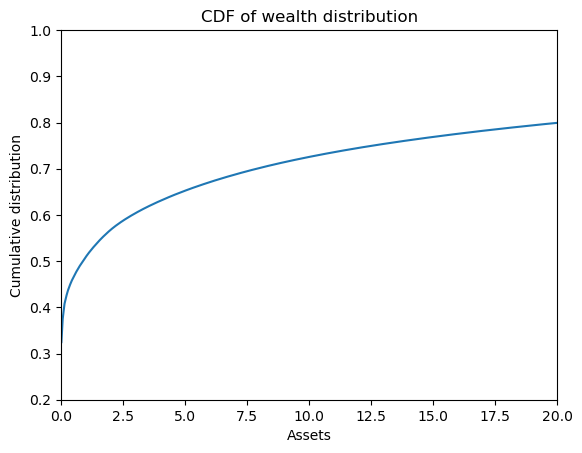

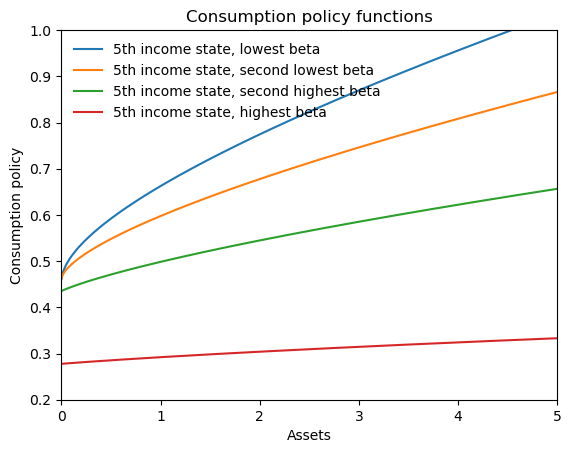

In [9]:
# Wealth distribution
D = ss.internals['hh_raw']['D'].sum(axis=0)
a_grid = ss.internals['hh_raw']['a_grid']
plt.plot(a_grid, D.cumsum())
plt.ylim([0.2, 1])
plt.xlim([0, 20])
plt.xlabel('Assets')
plt.ylabel('Cumulative distribution')
plt.title('CDF of wealth distribution')
plt.show()

# Consumption policy
c = ss.internals['hh_raw']['c']
plt.plot(a_grid, c[5, :], label='5th income state, lowest beta')
plt.plot(a_grid, c[11*1 + 5, :], label='5th income state, second lowest beta')
plt.plot(a_grid, c[11*2 + 5, :], label='5th income state, second highest beta')
plt.plot(a_grid, c[11*3 + 5, :], label='5th income state, highest beta')
plt.ylim([0.2, 1])
plt.xlim([0, 5])
plt.xlabel('Assets')
plt.ylabel('Consumption policy')
plt.title('Consumption policy functions')
plt.legend(frameon=False)
plt.show()

## (3) Computing Jacobians

We can compute Jacobians using the fake news algorithm directly from `hh`.

In [10]:
T = 400
J = hh.jacobian(ss, inputs=['rp', 'Z'], outputs=['C', 'A'], T=T)
M = J['C', 'Z']
A = J['A', 'Z']
Mr = J['C', 'rp']

Let's plot a few columns to see what we got here.

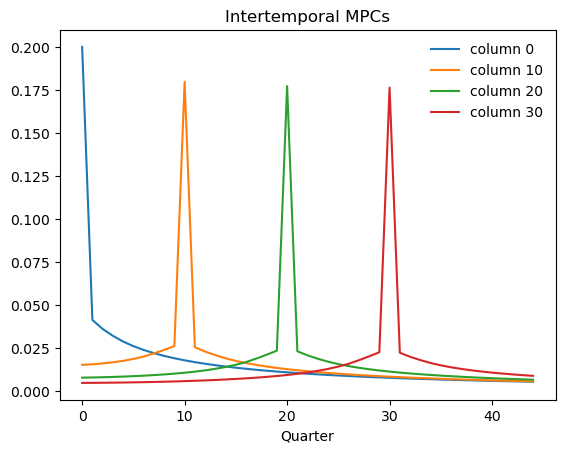

In [11]:
for s in [0, 10, 20, 30]:
    plt.plot(M[:45, s], label=f'column {s}')
plt.xlabel('Quarter')
plt.title('Intertemporal MPCs')
plt.legend(frameon=False);

## (4) Fiscal policy

Next, we solve for the IRF to a fiscal policy shock.

To do so, we describe a path for debt that we like (some AR(2)) and then compute the associated tax path that is consistent with the debt path, i.e. has zero NPV.

In [12]:
rho_B, rho = 0.975, 0.9

tax_cut_shock = rho**np.arange(T)  # some AR(1) shock
dB = np.empty_like(tax_cut_shock)
dB[0] = tax_cut_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] + tax_cut_shock[t]  # tax cut shock raises debt, but implicitly adjust taxes to get mean-reversion in debt 

# back out actual dT path (not the pure shock)
dT = np.empty_like(tax_cut_shock)
dT[0] = - dB[0]
dT[1:] = - dB[1:] + dB[:-1] * (1 + ss['rp'])  # tax cut shock, financed by debt

# print NPV of dT
npv_dT = np.sum(dT * (1 + ss['rp']) ** (-np.arange(T)))
print(f"NPV of tax shock: {npv_dT}")

NPV of tax shock: -7.286624256169771e-05


Let's plot the paths of `dT` and `dB`?

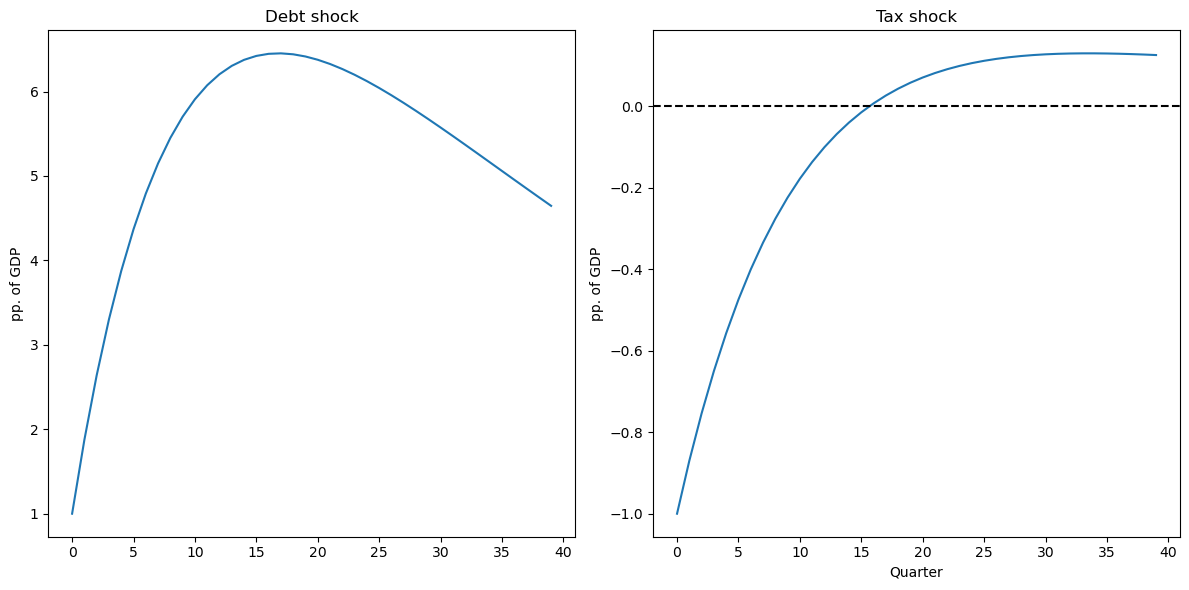

In [13]:
# make 1 x 2 panel figure showing dB and dT from 0 to 25
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dB[:40])
plt.title('Debt shock')
plt.ylabel('pp. of GDP')
plt.subplot(1, 2, 2)
plt.plot(dT[:40])
plt.axhline(0, color='k', linestyle='--')
plt.title('Tax shock')
plt.xlabel('Quarter')
plt.ylabel('pp. of GDP')
plt.tight_layout()

Now we are ready to solve for output. We will do so in two different ways:
- naive way $d\mathbf Y = (\mathbf I - \mathbf M)^{-1} (-\mathbf M d\mathbf T)$
- using asset market clearing, $d\mathbf Y = \mathbf A^{-1} d\mathbf B + d\mathbf T$ (which is the same as using the $\mathcal{M}$ matrix)

In [14]:
# solve using Naive IKC
dY_naive = np.linalg.solve(np.eye(T) - M, - M @ dT)

# solve using asset market clearing
dY_asset = np.linalg.solve(A, dB) + dT

Plot the different output responses and compare

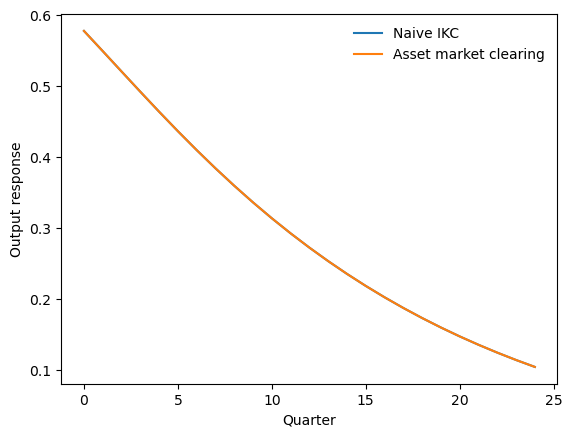

In [15]:
for dY, label in zip([dY_naive, dY_asset], ['Naive IKC', 'Asset market clearing']):
    plt.plot(dY[:25], label=label)
plt.xlabel('Quarter')
plt.ylabel('Output response')
plt.legend(frameon=False);

Reassuringly, the two give the same response. Still, numerically, it is the generally best practice to use asset market clearing (despite all the intuition and analytical results we can get from the IKC!).

Next, we compute (using closed form expressions) the responses in the RA and TA models.

 - For the RA model, it's just zero (due to Ricardian equivalence)
- For the TA model, we have $$dY_t = dG_t + \frac{\lambda}{1 - \lambda} (dG_t - dT_t) = - \frac{\lambda}{1 - \lambda} dT_t $$ where $\lambda$ is the share of hand-to-mouth agents in the TA model. This is because the TA model has a share $\lambda$ of hand-to-mouth agents. We get $\lambda$ from demanding that it hits a 0.20 average MPC, that is, $$(1 - \lambda) \left(1 - \frac{1}{1 + r^p}\right) + \lambda = M_{0,0}=0.20$$  

In [16]:
# RA response is zero because of Ricardian equivalence
dY_ra = np.zeros(T)

# Get the RA MPC: Just 1 - beta
mpc_ra = (1 - 1/(1+ss['rp']))

# TA Model:
# Get the share of hand-to-mouth agents
lam = (M[0, 0] - mpc_ra) / (1 - mpc_ra)
print(f"Share of hand-to-mouth agents in TA model: {lam}")

# Compute the TA output response
dY_ta = lam / (1 - lam) * (- dT)

Share of hand-to-mouth agents in TA model: 0.1959999999287549


Let's compare the responses across models.

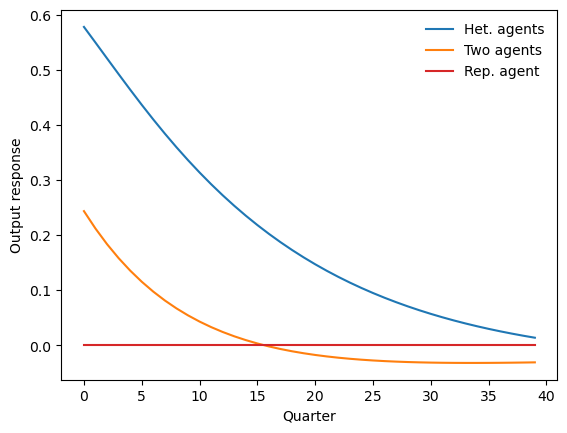

In [17]:
plt.plot(dY_asset[:40], label='Het. agents', color='C0')
plt.plot(dY_ta[:40], label='Two agents', color='C1')
plt.plot(dY_ra[:40], label='Rep. agent', color='C3')
plt.xlabel('Quarter')
plt.ylabel('Output response')
plt.legend(frameon=False);

We confirm that the heterogeneous agent response lies significantly above the representative agent response, and the two-agent model is somewhere in between.

In [18]:
npv_ta = np.sum(dY_ta * (1 + ss['rp']) ** (-np.arange(T)))
npv_ha = np.sum(dY_asset * (1 + ss['rp']) ** (-np.arange(T)))
print(f"NPV of TA response: {npv_ta:.2f}, NPV of HA response: {npv_ha:.2f}")

NPV of TA response: 0.00, NPV of HA response: 6.12


## (5) Monetary policy

Next, we feed in a basic monetary policy shock.

To do so, we specify an AR(1) interest rate shock `dr`. Notice that the ex-post interest rate is just equal to `dr`, but shifted by one period, giving `drp`.

In [19]:
dr = - 0.25 * 0.9 ** np.arange(T)
drp = np.zeros_like(dr)
drp[1:] = dr[:-1]

Since we have government debt, we have to specify what the government does in response to the interest rate shock. Here, we keep it simple: The government keeps debt repayment $(1 + r^p_t) B_{t-1}$ constant.

To do this, it adjusts debt by $$dB_t = - \frac{dr_t}{1+r} \cdot B $$ and taxes by $$ dT_t = - dB_t $$

In [20]:
dB_mp = - dr * ss['A'] / (1 + ss['rp'])
dT_mp = - dB_mp

We are ready to solve. Again, using the naive goods market approach and asset market clearing:

- Naive approach: $$d\mathbf Y = (\mathbf I - \mathbf M)^{-1} (\mathbf M^r \cdot d\mathbf{r}^p - \mathbf M \cdot d\mathbf T)$$
- Asset market approach: $$d\mathbf Y = \mathbf A ^{-1}\left(\mathbf J^{A,r} \cdot d\mathbf{r}^p + \mathbf d\mathbf B\right) + d\mathbf T$$ where $\mathbf J^{A,r}$ is the Jacobian of the asset market clearing condition with respect to the interest rate shock, and $\mathbf J^{A,T}$ is the Jacobian of the asset market clearing condition with respect to the tax shock.

In [21]:
dY_naive = np.linalg.solve(np.eye(T) - M, Mr @ drp - M @ dT_mp)
dY_asset = np.linalg.solve(A, - J['A', 'rp'] @ drp + dB_mp) + dT_mp

Let's compare the two in a plot.

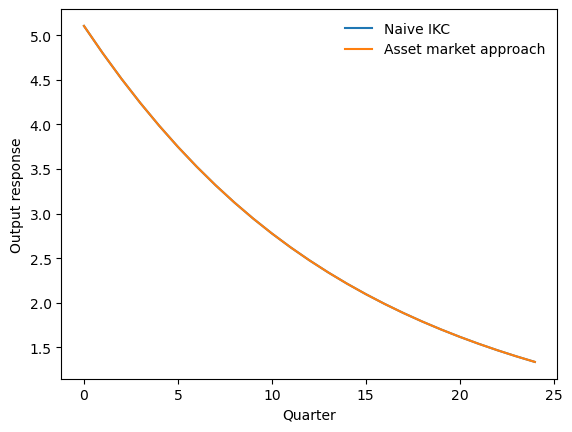

In [22]:
for dY, label in zip([dY_naive, dY_asset], ['Naive IKC', 'Asset market approach']):
    plt.plot(dY[:25], label=label)
plt.xlabel('Quarter')
plt.ylabel('Output response')
plt.legend(frameon=False);

Gladly no big difference here either! Still better to use asset market clearing.

Now compute RA and TA responses:

- For the RA model, we start with the Euler equation $$dY_t = dY_{t+1} - \frac{dr_t}{1 + r^p}$$ and then solve it forward: $$ dY_t^{ra} = - \frac{1}{1 + r^p} \sum_{s=0}^{\infty} dr_{t+s} $$

- For the TA model, the RA formula only applies to a share $1 - \lambda$ of households. The remaining hand-to-mouth households spend out of after-tax income: $$ dY_t = (1 - \lambda) dY_{t}^{ra} + \lambda (dY_t - dT_t) $$ Solving for dY_t we get $$ dY_t^{ta} = dY_{t}^{ra} - \frac{\lambda}{1 - \lambda} dT_t $$

In [23]:
dY_ra = - np.cumsum(dr[::-1])[::-1] / (1 + ss['rp'])
dY_ta = dY_ra - lam / (1 - lam) * dT_mp

Comparison with RA response shows that it's not too different!

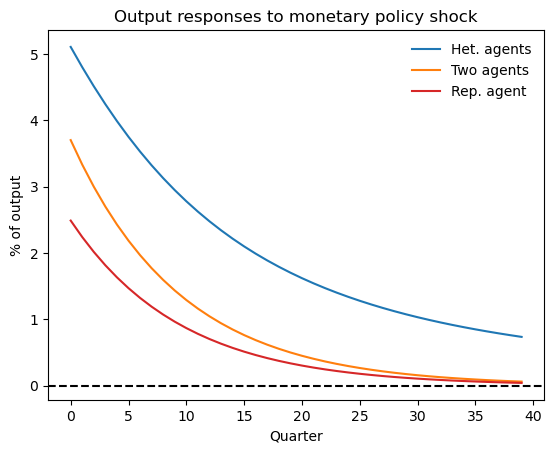

In [24]:
plt.plot(dY_asset[:40], label='Het. agents', color='C0')
plt.plot(dY_ta[:40], label='Two agents', color='C1')
plt.plot(dY_ra[:40], label='Rep. agent', color='C3')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quarter')
plt.ylabel('% of output')
plt.title('Output responses to monetary policy shock')
plt.legend(frameon=False);

## Blocks and Models

So far, we have solved models by hand, but using the Jacobians of the `HetBlock`. However, as models get more complicated, this approach becomes cumbersome. Instead, we can use the `sequence-jacobian` toolbox to define a model as a collection of `Block`s, and then solve for steady states and impulse responses.

To do so, we introduce two more blocks, so called `SimpleBlock`s.

In [25]:
@sj.simple
def fiscal(B, rp, G, Y):
    T = (1 + rp) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = Y - C - G
    return asset_mkt, goods_mkt

These blocks also have inputs and outputs, but are much simpler explicit functions. Not as complicated as the `HetBlock` above!

In [26]:
# Fiscal inputs and outputs
print('Fiscal block inputs: ' + str(fiscal.inputs))
print('Fiscal block outputs: ' + str(fiscal.outputs))

Fiscal block inputs: ['B', 'rp', 'G', 'Y']
Fiscal block outputs: ['T', 'Z', 'deficit']


Now we can put these `Block`s together to create a model!

In [27]:
ha = sj.create_model([fiscal, hh, mkt_clearing], name="Simple HA Model")

Let's see what kind of animal `ha` is.

In [28]:
print(ha)
print('It has inputs: ' + str(ha.inputs))
print('It has outputs: ' + str(ha.outputs))

<Model 'Simple HA Model'>
It has inputs: ['B', 'rp', 'G', 'Y', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'dbeta', 'beta_hi']
It has outputs: ['T', 'Z', 'deficit', 'A', 'C', 'asset_mkt', 'goods_mkt']


A model is really a `CombinedBlock` that composes blocks together, like a composition of functions: First, it evaluates the fiscal block, then the household block, and finally the market clearing block, always re-using inputs wherever possible.

Many of the inputs are model parameters, such as `eis`, `beta`, `rho_e`, etc. But some are actually aggregates we want to solve ("unknowns") for, like `Y`, or shocks ("exogenous inputs"), like `B` or `G`. One nice feature in SSJ is that we don't have to distinguish the two at this point. This gives us flexibility to shock whatever we want later on.

Some of the outputs are "targets", such as `goods_mkt` or `asset_mkt`. By Walras' law, it is sufficient to impose either `asset_mkt` or `goods_mkt`.

We can now evaluate the steady state of the whole model.

In [29]:
calibration.update({'B': ss['A'],
                    'G': 1 - ss['C'],
                    'T': ss['rp'] * ss['A'],
                    'Y': 1})

In [30]:
ss_ha = ha.steady_state(calibration)

Check market clearing conditions

In [31]:
ss_ha['goods_mkt'], ss_ha['asset_mkt']

(-4.530474811970109e-07, 1.1330133080633686e-05)

Great! We have a steady state.

Now we can use SSJ to feed in shocks, e.g. `dB` for the tax cut above:

In [32]:
irf_pe = ha.impulse_linear(ss_ha, inputs={'B': dB})

Let's plot this for consumption

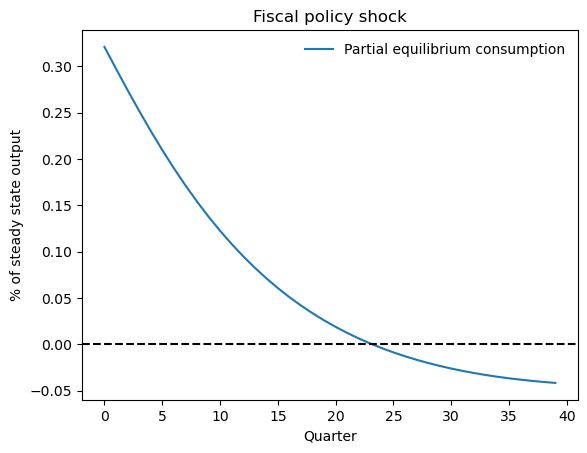

In [33]:
plt.plot(irf_pe['C'][:40], label='Partial equilibrium consumption')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quarter')
plt.ylabel('% of steady state output')
plt.legend(frameon=False)
plt.title('Fiscal policy shock');

But we did not impose asset (or goods) market clearing:

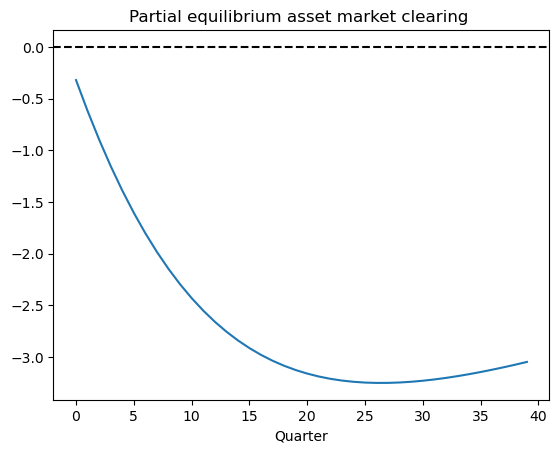

In [34]:
plt.plot(irf_pe['asset_mkt'][:40], label='Partial equilibrium consumption');
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quarter')
plt.title('Partial equilibrium asset market clearing ');

Let's clear the asset market by adjusting output `Y` along the way.

In [35]:
irf = ha.solve_impulse_linear(ss_ha, unknowns=['Y'], targets=['asset_mkt'], inputs={'B': dB})

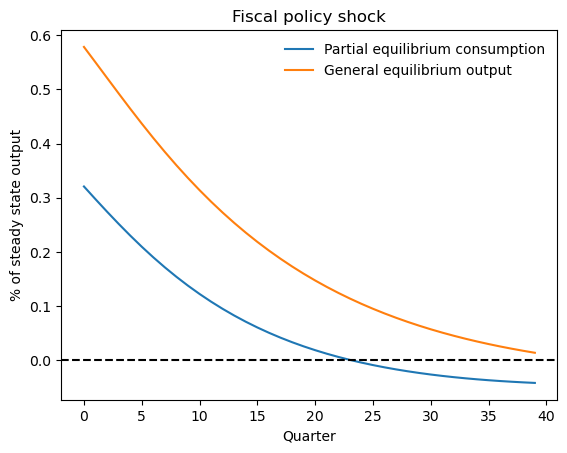

In [36]:
plt.plot(irf_pe['C'][:40], label='Partial equilibrium consumption')
plt.plot(irf['Y'][:40], label='General equilibrium output')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quarter')
plt.ylabel('% of steady state output')
plt.legend(frameon=False)
plt.title('Fiscal policy shock');

Try other shocks:

(1) Patience shock

In [37]:
irf = ha.solve_impulse_linear(ss_ha, unknowns=['Y'], targets=['asset_mkt'], inputs={'beta_hi': 0.9 ** np.arange(T)})

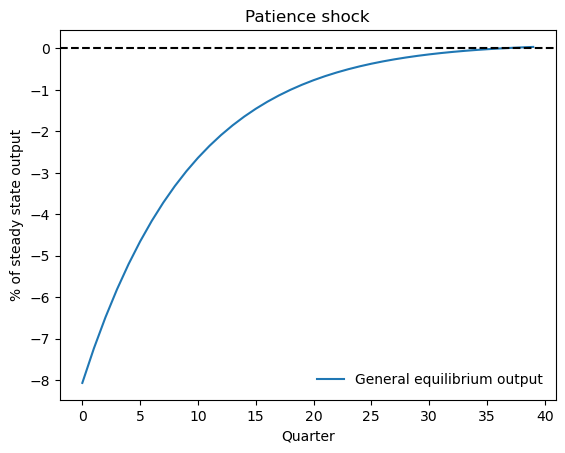

In [38]:
plt.plot(irf['Y'][:40], label='General equilibrium output')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quarter')
plt.ylabel('% of steady state output')
plt.legend(frameon=False)
plt.title('Patience shock');

(2) Monetary shock

In [39]:
drp = np.zeros(T)
drp[1:] = -0.25 * 0.9 ** np.arange(T-1)  # AR(1) monetary policy shock
irf = ha.solve_impulse_linear(ss_ha, unknowns=['Y'], targets=['asset_mkt'], inputs={'rp': drp})

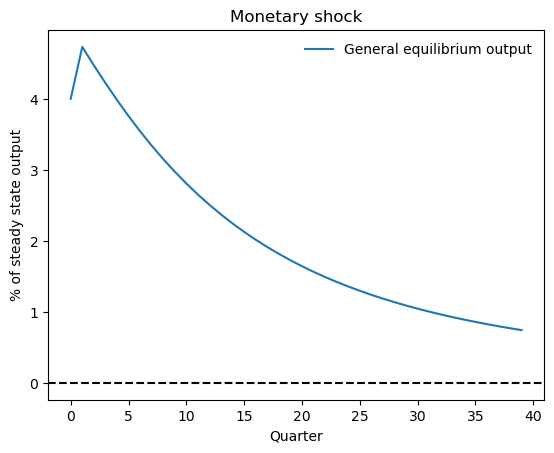

In [40]:
plt.plot(irf['Y'][:40], label='General equilibrium output')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quarter')
plt.ylabel('% of steady state output')
plt.legend(frameon=False)
plt.title('Monetary shock');

(3) Income risk shock

In [41]:
irf = ha.solve_impulse_linear(ss_ha, unknowns=['Y'], targets=['asset_mkt'], inputs={'sd_e': 0.90 ** np.arange(T)})

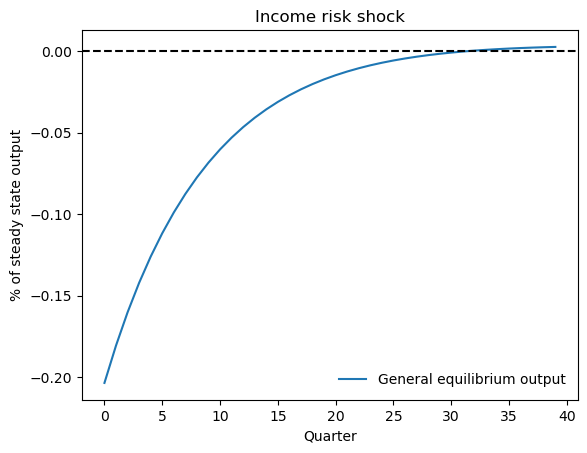

In [42]:
plt.plot(irf['Y'][:40], label='General equilibrium output')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Quarter')
plt.ylabel('% of steady state output')
plt.legend(frameon=False)
plt.title('Income risk shock');